In [1]:
import sys
from pathlib import Path

import xarray as xr
import pandas as pd
import metobs_toolkit
print(metobs_toolkit.__version__)

0.4.1a


# Verification pipeline CS-MASK

## Importing observations



In [2]:
#Set Paths to files
obsdatafile = metobs_toolkit.demo_datafile
metadatafile = metobs_toolkit.demo_metadatafile
templatefile = metobs_toolkit.demo_template


In [3]:
dataset = metobs_toolkit.Dataset()
dataset.import_data_from_file(
                    template_file=templatefile,
                    input_data_file=obsdatafile,
                    input_metadata_file=metadatafile,
                    )


Luchtdruk is present in the datafile, but not found in the template! This column will be ignored.
Neerslagintensiteit is present in the datafile, but not found in the template! This column will be ignored.
Neerslagsom is present in the datafile, but not found in the template! This column will be ignored.
Rukwind is present in the datafile, but not found in the template! This column will be ignored.
Luchtdruk_Zeeniveau is present in the datafile, but not found in the template! This column will be ignored.
Globe Temperatuur is present in the datafile, but not found in the template! This column will be ignored.
The following columns are present in the data file, but not in the template! They are skipped!
 ['Rukwind', 'Neerslagintensiteit', 'Neerslagsom', 'Luchtdruk_Zeeniveau', 'Luchtdruk', 'Globe Temperatuur']
The following columns are found in the metadata, but not in the template and are therefore ignored: 
['sponsor', 'stad', 'Network', 'benaming']


### metadata

Extract extra metadata to serve as aggregation class for verification.

In [4]:
dataset.get_LCZ()

,LCZ
name,
vlinder01,Low plants (LCZ D)
vlinder02,Large lowrise
vlinder03,Open midrise
vlinder04,Sparsely built
vlinder05,Water (LCZ G)
vlinder06,Scattered Trees (LCZ B)
vlinder07,Compact midrise
vlinder08,Compact midrise
vlinder09,Scattered Trees (LCZ B)


### Apply syncronization

In [5]:
#Coarsen if needed
dataset.resample(target_freq='1h')

The present gaps are removed, new gaps are constructed for wind_speed data of station vlinder02..
The present gaps are removed, new gaps are constructed for wind_direction data of station vlinder02..
The present gaps are removed, new gaps are constructed for temp data of station vlinder02..
The present gaps are removed, new gaps are constructed for humidity data of station vlinder02..


### Apply QC 

In [6]:
target = 'temp'


#1. gross value check
dataset.gross_value_check(
            target_obstype=target,
            lower_threshold=-10.0,
            upper_threshold=42.0)

#2. persistence check
# dataset.persistence_check(
#             target_obstype=target,
#             timewindow='4h',
#             min_records_per_window=3)

#3. repetitions check
dataset.repetitions_check(
            target_obstype=target,
            max_N_repetitions=5
)

#4. repetitions check
# dataset.step_check(
#             target_obstype=target,
#             max_increase_per_second = 8.0 / 3600.0, #depends on standard unit!
#             max_decrease_per_second = -10.0 / 3600.0) #depends on standard unit!


/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/qc_collection/repetitions_check.py:62: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  groups.get_group(
/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/qc_collection/repetitions_check.py:62: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  groups.get_group(
/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/qc_collection/repetitions_check.py:62: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  groups.get_group(
/home/thoverga/Documen

### Apply GF

### Inspect the data


                            General info of Dataset                             


--- Observational info ---

Dataset instance with:
  -28 number of stations
  -40320 number of records
  -4 types of sensor data are present.
  -Observations from 2022-09-01 00:00:00+00:00 -> 2022-09-15 23:00:00+00:00
  -Outlier info:
    -A total of {outldf.shape[0]} outliers are present.
      -label counts:
        -repetitions outlier: 1676
    -For these obstyes: ['temp']
    -For 28 stations: ['vlinder05', 'vlinder01', 'vlinder02', 'vlinder03', 'v...
  -Gaps info:
    -No gaps present.

--- Metadata info ---

  -28 number of stations
  -The following metadata is present: ['lat', 'lon', 'LCZ', 'school', 'geomet...

--- Modeldata info ---

  -Dataset instance without modeldata.



<Axes: title={'center': 'temp data.'}, xlabel='Timestamps (in UTC)', ylabel='temp (degree_Celsius)'>

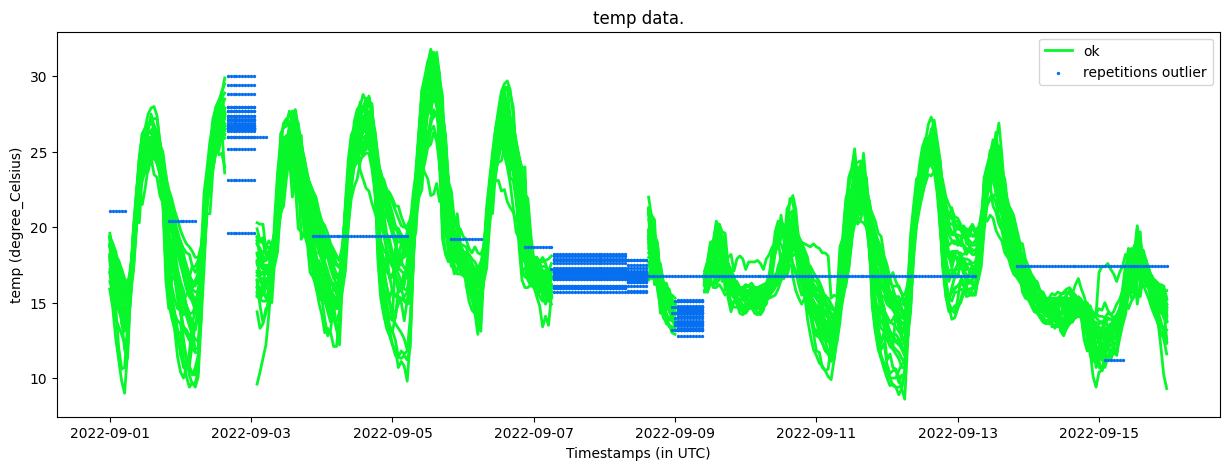

In [7]:
dataset.get_info()
dataset.make_plot(obstype = 'temp', colorby='label')

## Import model output

Note: ERA5 data can be extracted directly from the datataset, then skip this section.

In [8]:
modelid = "AromeCy48t3_belgium_1.4"
folder = Path("/media/thoverga/WORK/deode_runs/belgium13_part/archive/2020/08/01/00")
variable_def=metobs_toolkit.default_SFX_fields

In [9]:
def load_all_netcdf_files(folder: Path, fileglobstr="*.nc", **kwargs) -> xr.Dataset:
    if not folder.is_dir():
        raise NotADirectoryError(f"{folder} is not a directory")
    files = sorted([str(f) for f in folder.glob(fileglobstr) if f.is_file()])
    if not files:
        raise FileNotFoundError(f"No NetCDF files found in {folder}")
    return xr.open_mfdataset(files, combine='by_coords', **kwargs)

def load_netcdf_file(file_path: Path, **kwargs) -> xr.Dataset:
    if not file_path.is_file():
        raise FileNotFoundError(f"{file_path} does not exist or is not a file")
    return xr.open_dataset(str(file_path), **kwargs)


In [10]:
# modeldataset = load_all_netcdf_files(folder, fileglobstr="*.sfx.nc", engine='netcdf4')
# mod = metobs_toolkit.ModelDataset(
#                         modelID=modelid,
#                         dataset=modeldataset,
#                         field_defenitions=metobs_toolkit.default_SFX_fields)


### Plot spatial


## Clip spatial data to timeseries

The goal is that the spatial modeloutput is converted to timeseries at the stations locations. This is done by importing the modeldata to the (observational) dataset.


In [11]:
# dataset.get_NWP_timeseries_data(modeldataset=mod)

### (Optional) era5 as modeldata

In [12]:
era5_manager = metobs_toolkit.default_GEE_datasets["ERA5-land"]

# era5_data = dataset.get_gee_timeseries_data(
#     geedynamicdatasetmanager=era5_manager,
#     startdt_utc=None,  # raises error in metadata-only case
#     enddt_utc=None,
#     target_obstypes=["temp"],
#     get_all_bands=False,
#     drive_filename=None,
#     # drive_folder="gee_timeseries_data",
#     force_direct_transfer=False,
#     force_to_drive=False,
# )


dataset.import_gee_data_from_file(filepath="/home/thoverga/Downloads/ERA5-land_vlinders_demo.csv",
                                  geedynamicdatasetmanager=era5_manager)



temp     pressure
name      datetime                                         
vlinder01 2022-09-01 00:00:00+00:00  18.394525  1017.902695
          2022-09-01 01:00:00+00:00  17.799753  1017.461797
          2022-09-01 02:00:00+00:00  17.415353  1017.439766
          2022-09-01 03:00:00+00:00  16.820734  1017.180352
          2022-09-01 04:00:00+00:00  16.450281  1016.983633
...                                        ...          ...
vlinder28 2022-09-15 20:00:00+00:00  14.408151  1010.590937
          2022-09-15 21:00:00+00:00  13.831171  1010.626992
          2022-09-15 22:00:00+00:00  13.174661  1011.179062
          2022-09-15 23:00:00+00:00  12.936517  1010.934922
          2022-09-16 00:00:00+00:00  12.735727  1010.891836

[10108 rows x 2 columns]

### timeseries plots



In [13]:
# dataset.get_station('vlinder05').make_plot(obstype='temp', show_modeldata=True,
#                                            trg_modelID=modelid)


# Verification

Verification is handled by the `metobs_toolkit.Verification` class. In pracktice, this is just a wrapper on the Dataset/Station class. But this id done so to keep it in parallel of these classes, rather than adjusting these classes.

In [14]:
shift_tolerance = pd.Timedelta('5min')
target_obstype='temp'

In [15]:

ver = metobs_toolkit.Verification(obj=dataset)
verifdf = ver._create_verifdf(target_obstype=target_obstype,
                              shift_tolerance=shift_tolerance)



(<Axes: title={'center': 'Timeseries of temp (obs & fc)\n (originates from temperature_2m)'}, ylabel='temp (degree_Celsius)'>,
 <Axes: title={'center': 'Residuals'}, ylabel='fc - obs (in degree_Celsius)'>)

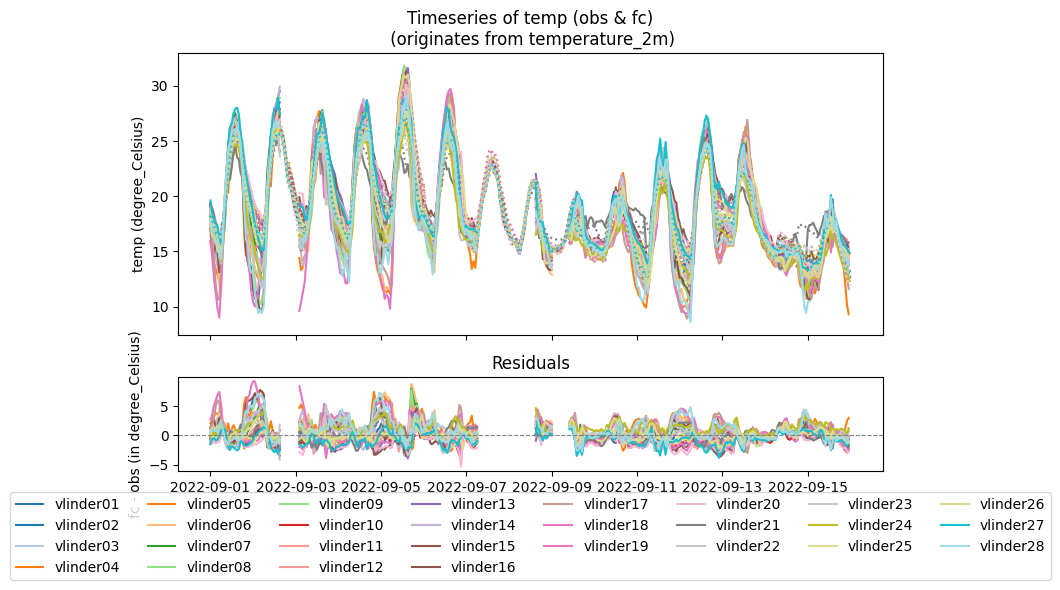

In [16]:
ver.plot_timeseries_of_obs_and_fc(target_obstype=target_obstype,
                                  )

### Aggregationgroups


In [17]:
agg_scores_group = ['datetime'] #Include all levels needed for the plot
xax_lvl = 'datetime'
colorlvl = None
to_plot_value= None
to_plot_lvl = 'score'

In [18]:
scoringdf = ver.get_scoring_df(
            target_obstype=target_obstype,
            groupby=agg_scores_group,
            shift_tolerance=shift_tolerance)
print(scoringdf.head())

datetime                   score     
2022-09-01 00:00:00+00:00  rmse           1.050763
                           mae            0.882958
                           bias          -0.022778
                           samplesize    27.000000
2022-09-01 01:00:00+00:00  rmse           1.260945
Name: value, dtype: float64


/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/verification.py:161: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


<Axes: title={'center': 'None values grouped per score.'}, xlabel='datetime'>

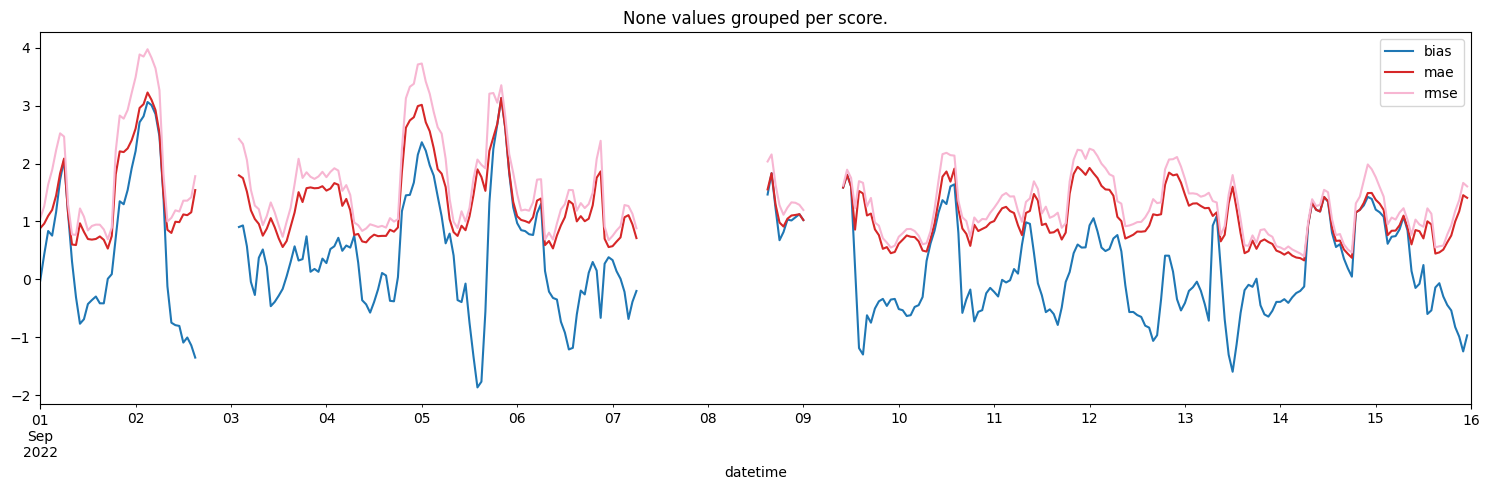

In [19]:
#Make plot

#Optional: filter out scores with other 'units' 
blackscores = ['samplesize'] 
scoringdf = scoringdf[~scoringdf.index.get_level_values('score').isin(blackscores)]

ver.plot_scoring(scoringdf=scoringdf,
                 xaxis_level=xax_lvl,
                 color_level=colorlvl,
                to_plot_value=to_plot_value,
                to_plot_level=to_plot_lvl)

/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/verification.py:161: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


<Axes: title={'center': 'None values grouped per score.'}, xlabel='name'>

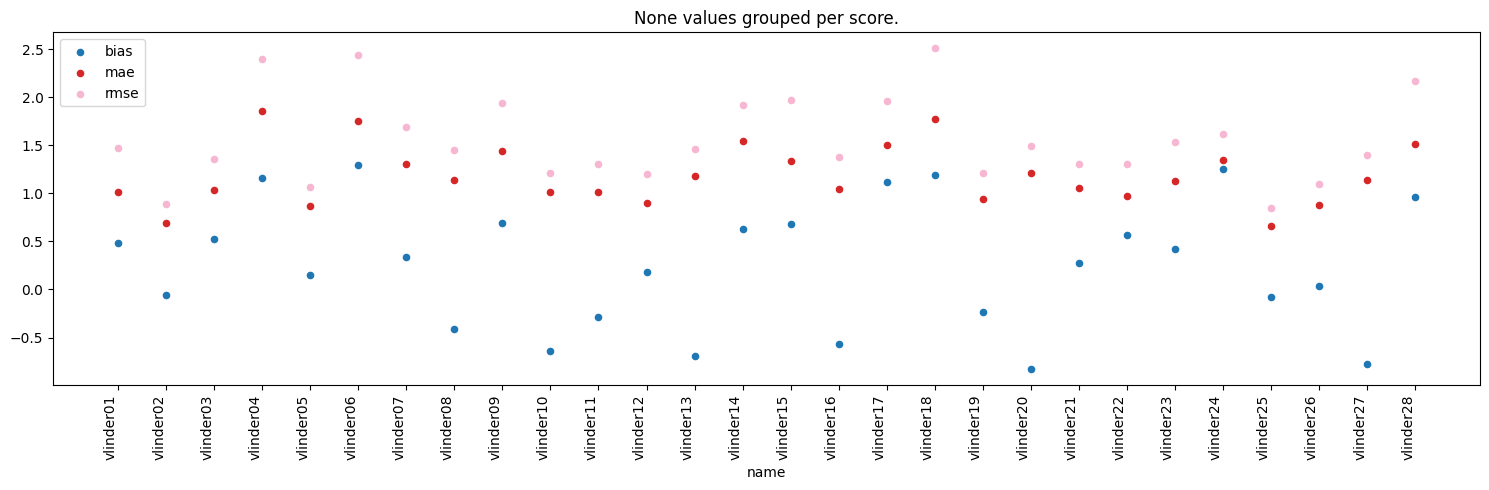

In [20]:
# aggregated to stationnames
agg_scores_group = ['name'] #Include all levels needed for the plot
xax_lvl = 'name'
colorlvl = None
to_plot_value= None
to_plot_lvl = 'score'

scoringdf = ver.get_scoring_df(
            target_obstype=target_obstype,
            groupby=agg_scores_group,
            shift_tolerance=shift_tolerance)

blackscores = ['samplesize'] 
scoringdf = scoringdf[~scoringdf.index.get_level_values('score').isin(blackscores)]

ver.plot_scoring(scoringdf=scoringdf,
                 xaxis_level=xax_lvl,
                 color_level=colorlvl,
                to_plot_value=to_plot_value,
                to_plot_level=to_plot_lvl)

### Diurnal aggregation

In this section we make compute diurnal scores and plots.


/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/verification.py:161: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


<Axes: title={'center': 'rmse values grouped per LCZ.'}, xlabel='hour', ylabel='rmse'>

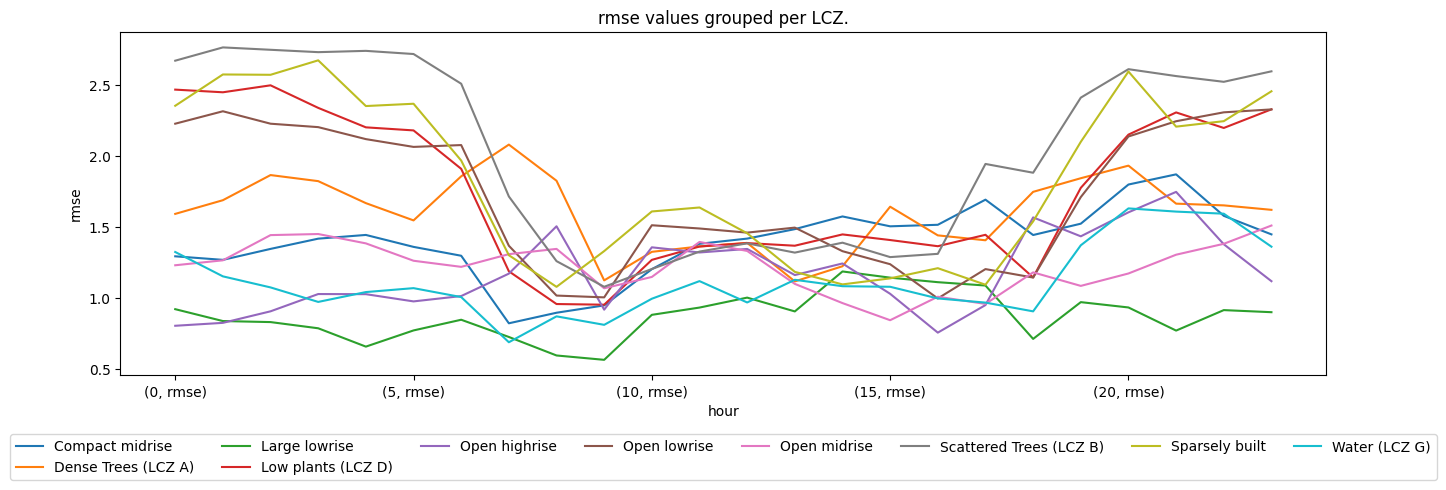

In [21]:
agg_scores_group = ['hour', 'LCZ'] #hour makes it diurnal !! 
xax_lvl = 'hour'
colorlvl = 'LCZ'
to_plot_value= 'rmse' # thus all scores under the 'score' lvel
to_plot_lvl = 'score'

#Compute scores
scoringdf = ver.get_scoring_df(
            target_obstype=target_obstype,
            groupby=agg_scores_group,
            shift_tolerance=shift_tolerance)

#Drop samplesizes
blackscores = ['samplesize'] 
scoringdf = scoringdf[~scoringdf.index.get_level_values('score').isin(blackscores)]

#plot
ver.plot_scoring(
        scoringdf=scoringdf,
        xaxis_level=xax_lvl,
        color_level=colorlvl,
        to_plot_value=to_plot_value,
        to_plot_level=to_plot_lvl)